#### Reading of the manual anotated files from Johannes

Some of the annotations are 128 some are 256. The annotations are mostly done on 256 scale. So we currently upscale to 256x256, for both the manual annotations and the dcim images.

In [3]:
import struct
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import os
import pandas as pd
import os
import dicom
%matplotlib inline

In [6]:
# Read the manual annotations and scales them down to (128,128)
def readAnotations(pathFileName, skip):
    global f, numByte, fileNameRead, byte, width, decoded, height, allPixel, slices
    f = open(pathFileName, "rb")
    try:
        numByte = 0
        fileNameRead = ""
        byte = f.read(1)
        while byte != "":
            byte = f.read(1)
            if numByte < skip: #The filename is coded in the binary file, hence we skip a few bytes
                fileNameRead += byte
            else:
                fileNameRead += byte
                width = decoded = struct.unpack('>I', f.read(4))[0]  # This is magic, we have big-endian coding
                height = decoded = struct.unpack('>I', f.read(4))[0]
                #print("Read header of [" + fileNameRead + "] width = , " + str(width) + " height=" + str(height))
                allPixel = np.fromfile(f, dtype='>I', count=-1, sep='')
                slices = len(allPixel) / (width * height) 
                # Reshaping and downscaling
                l = np.sqrt(len(allPixel))
                img = np.reshape(allPixel / 256.0, (l,l))
                if l < 256:
                    print("--------->     Rescaling the Annotation")
                    dd = cv2.resize(img,(256,256))
                else:
                    dd = img
                Y = np.reshape(dd * 256, (1, 256, 256))
                # print("---->  " + str(allPixel.max()) + "  " + str(np.unique(allPixel)) + " " + str(l))
                f.close()
                return Y,l
            numByte += 1
    finally:
        f.close()

#### This is just for testing readAnnotation

---->  0  [0] 256.0


TypeError: tuple indices must be integers, not tuple

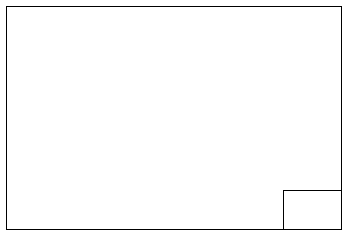

In [4]:
#path = "/Users/oli/Proj_Large_Data/Deep_Learning_MRI/insel_annotated/ADC-contouring-test-case/3-ep2d_diff_3scan_p3_m128_ADC/iov/"
path = '/home/dueo/data/Inselspital_2015_07_08/metastasis/001_3SUIUNLJQMTGZRVTJM7LWTPHDA======/3SUIUNLJQMTGZRVTJM7LWTPHDA======-20150130-0/3-ep2d_diff_3scan_p3_m128_ADC/iov/'
fig = plt.figure()
plt.xticks([])
plt.yticks([])
files = os.listdir(path)
for i,file in enumerate(files):
    Y = readAnotations(path + file, len(file))
    a = fig.add_subplot(5, 5, i, xticks=[], yticks=[])  
    plt.imshow(Y[0,:,:], cmap=plt.get_cmap('gray'))
    print(file + ' ' + str(Y.shape) + " " + str(Y.max()))


## Creation of a list of files
##### For GBM
```
> dueo@srv-lab-t-706:~/data/Inselspital_2015_07_08/GBM
find $PWD -name '*.dcm' > ../list_GBM.txt
dueo@srv-lab-t-706:~/data/Inselspital_2015_07_08/GBM$ wc ../list_GBM.txt 
  1211   1211 274828 ../list_GBM.txt
dueo@srv-lab-t-706:~/data/Inselspital_2015_07_08/GBM$ ls -l1R | grep dcm.iov | wc
   1211   10899  142277
```
The same number of dcm.iov files as there are dcm files.

The same for metastasis.

```
dueo@srv-lab-t-706:~/data/Inselspital_2015_07_08/metastasis$ wc ../list_meta.txt 
  1223   1223 288175 ../list_meta.txt
dueo@srv-lab-t-706:~/data/Inselspital_2015_07_08/metastasis$ ls -l1R | grep dcm.iov | wc
   1119   10071  132691
```

*There are some files missing in the metastasis case*


In [4]:
#dcm_files = pd.read_csv('/home/dueo/data/Inselspital_2015_07_08/list_GBM.txt', header=None)
dcm_files = pd.read_csv('/home/dueo/data/Inselspital_2015_07_08/list_meta.txt', header=None)
dcm_files = dcm_files.icol(0)
type(dcm_files)

pandas.core.series.Series

### Creation of the pickeled objects

In [7]:

missing = 0
allSlices = 0 

#numFiles = 1211 # For GBM
numFiles = 1003  # For Metastasis

X = np.zeros((numFiles,1,256,256)) #Change after all slices have been found
Y = np.zeros((numFiles,1,256,256))
Names = [None] * numFiles
l = np.zeros(numFiles)
for i, fileNameAbs in dcm_files.iteritems():
    fn = os.path.basename(fileNameAbs)
    pathName = os.path.dirname(fileNameAbs)
    fnIOV = os.path.join(pathName, "iov", fn + str(".iov"))  
    if os.path.exists(fnIOV) == False:
        missing += 1
    else:
        Yp,l1 = readAnotations(fnIOV, len(fn) + 4) #We add '.iov'
        plan = dicom.read_file(fileNameAbs)
        Xp = plan.pixel_array
        dd = cv2.resize(Xp,(256,256))
        ddd = np.reshape(dd,(1,256,256))
        ##
        ## We only add if we have 256 pixel annotated in the 
        if (l1 != 256):
            print(str(np.shape(Yp)) + " " + str(np.shape(ddd)) + str(np.max(Y[:,:,:,:])))
        else:
            l[allSlices] = l1 
            X[allSlices,] = ddd
            Y[allSlices,] = Yp
            Names[allSlices] = fn
            allSlices += 1
        
print("Number of missings " + str(missing) + " Number of all slices " + str(allSlices))

--------->     Rescaling the Annotation
(1, 256, 256) (1, 256, 256)4.0
--------->     Rescaling the Annotation
(1, 256, 256) (1, 256, 256)4.0
--------->     Rescaling the Annotation
(1, 256, 256) (1, 256, 256)4.0
--------->     Rescaling the Annotation
(1, 256, 256) (1, 256, 256)4.0
--------->     Rescaling the Annotation
(1, 256, 256) (1, 256, 256)4.0
--------->     Rescaling the Annotation
(1, 256, 256) (1, 256, 256)4.0
--------->     Rescaling the Annotation
(1, 256, 256) (1, 256, 256)4.0
--------->     Rescaling the Annotation
(1, 256, 256) (1, 256, 256)4.0
--------->     Rescaling the Annotation
(1, 256, 256) (1, 256, 256)4.0
--------->     Rescaling the Annotation
(1, 256, 256) (1, 256, 256)4.0
--------->     Rescaling the Annotation
(1, 256, 256) (1, 256, 256)4.0
--------->     Rescaling the Annotation
(1, 256, 256) (1, 256, 256)4.0
--------->     Rescaling the Annotation
(1, 256, 256) (1, 256, 256)4.0
--------->     Rescaling the Annotation
(1, 256, 256) (1, 256, 256)4.0
------

In [8]:
np.histogram(Y, bins=[0, 1, 2, 3,4,5,6])

(array([65051859,    69261,   606988,     3608,      892,        0]),
 array([0, 1, 2, 3, 4, 5, 6]))

#### Small issue Y $\in$ {0,1,2,3,4,5} for Metastatsis
In the case of metastasis some values are outside the 0,1,2. This might be due to upscaling Y from 128x128 to 256x256, we ignore this for the moment. 
```
(array([65051859,    69261,   606988,     3608,      892,        0]),
 array([0, 1, 2, 3, 4, 5, 6]))
```

In [13]:
Y[Y == 3] = 0
Y[Y == 4] = 0
np.histogram(Y, bins=[0, 1, 2, 3,4,5,6])

(array([65056359,    69261,   606988,        0,        0,        0]),
 array([0, 1, 2, 3, 4, 5, 6]))

### Metastasis setting the tumor indicator from 2-->3
For the later use it is convenient to set the tumor indicator to 3 in the case of metastasis. So we have:

* 0 Not Marked
* 1 Tumour (GBM)
* 2 Tumour (Metastasis)

In [14]:
Y[Y == 2] = 3
np.histogram(Y, bins=[0, 1, 2, 3,4,5,6])

(array([65056359,    69261,        0,   606988,        0,        0]),
 array([0, 1, 2, 3, 4, 5, 6]))

In [15]:
import pickle
np.shape(X)
np.shape(Y)
Names[1]
maxIdx = allSlices - 1
print(maxIdx)
with open('/home/dueo/data/Inselspital_2015_07_08/META.pickle', 'wb') as f:
    pickle.dump((Names[0:maxIdx],X[0:maxIdx,:,:,:],Y[0:maxIdx,:,:,:],l[0:maxIdx]), f, -1)
%ls -lh /home/dueo/data/Inselspital_2015_07_08/

1002
total 3.1G
drwxr-xr-x 62 dueo dueo  4.0K Jun  5 04:43 GBM/
-r--r--r--  1 dueo dueo  1.1G Jul 16 17:31 GBM.pickle
-rw-r--r--  1 dueo dueo  509M Jun 18 16:22 GBM.zip
-rw-r--r--  1 dueo dueo  269K Jun 23 13:05 list_GBM.txt
-rw-r--r--  1 dueo dueo  282K Jun 23 13:07 list_meta.txt
-rw-r--r--  1 dueo dueo 1003M Jul 17 14:01 META.pickle
drwxr-xr-x 68 dueo dueo  4.0K Jun  5 05:26 metastasis/
-rw-r--r--  1 dueo dueo  455M Jun 18 16:21 metastasis.zip
